In [7]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

import tensorflow as tf
import keras

In [8]:
pd.options.display.max_rows = 1000

In [9]:
df = pd.read_csv('./data/train.csv')

In [96]:
import re

num_re = re.compile('([0-9X]+[\-\.]+[\-.0-9X]+|[0-9X]+[.0-9X]+\%|[0-9X]+[년월일천만억원]+)')
#num_re = re.compile('[0-9X]+[년월일천만억원]+|[0-9X]+[\-\.]+[\-.0-9X]+')
fon_re = re.compile('[0-9X]{2,4}-[0-9Xx]{2,4}-[0-9Xx]{4}')

deny_re = re.compile("무료거부|무료수신거부")


In [97]:
def parse_sentence(sentence):
    ret = []
    nouns = []
    etc = []
    condition = False
    
    if sentence[:4] == '(광고)':
        etc.append(1)
        sentence = sentence[4:]
    else:
        etc.append(0)
    
    # 무료거부 메시지 있는가
    etc.append(1 if len(deny_re.findall(sentence)) > 0 else 0)
    # 전화번호 형식이 있는가
    etc.append(1 if len(fon_re.findall(sentence)) > 0 else 0)
    
    prev_pos = ''
    count_ec, count_m, count_n, count_vv = 0, 0, 0, 0
    ss = ''
    for word in mecab.pos(sentence):
        # 계시다면 등에서 다면이 N으로 파싱됨
        if word[1][:1] == 'S' and word[0][:1] not in '()':
            # 숫자나 X등
            if ss == '' and word[1] == 'SF':
                # 점으로 시작하는 경우는 무시
                pass
            else:
                ss += word[0]
        elif len(ss) > 0:
            # 숫자 뒤에 명사가 와서 의미를 만드는 경우 : 1월, 20일, 1만원 등
            if word[1][:1] == 'N':
                ss += word[0]
            nouns.append(re.sub('[0-9.X]+', 'X', ss))
            ss = ''
            
        if word[1][:1] == 'M':
            nouns.append(word[0])
            count_m += 1
        elif word[1][:1] == 'N':
            count_n += 1
            if word[0][:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
            elif word[0] == '시' and prev_pos[:1] == 'N':  # 넣으나 마나.. 왜 그렇지?
                condition = True
            else:
                nouns.append(word[0])
        # 도 : 여도, 라도
        # 면 : 라면, 면
        elif word[1] == 'EC':
            count_ec += 1
            if word[0][-1:] in ('면', '도') or word[0][-2:] in ('도록'):
                condition = True
        elif word[1][:1] == 'V':
            count_vv += 1
            nouns.append(word[0])
        elif word[1][-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            # nouns가 꼭 명사를 뜻하는 게 아니고 특색있는 키워드 모두를 포함
            nouns.append(word[0])
            ret.append([word[0], condition, nouns])
            nouns = []
            condition = False
        prev_pos = word[1]
    if len(nouns) > 0:
        nouns.append(word[0])
        ret.append([word[0], condition, nouns])
    
    etc += [count_ec, count_m, count_n, count_vv]
    
    # 가장 많은 단어를 가진 조건절만 남기고 나머지는 일반문장으로 원복
    max_len, selected = 0, -1
    for idx, item in enumerate(ret):
        if item[1] == True and len(item[2]) > max_len:
            selected, max_len = idx, len(item[2])
        ret[idx][1] = False
    if selected >= 0:
        ret[selected][1] = True
    return ret, etc

In [98]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited, etc = parse_sentence(item.text)
    # 일반 피쳐를 여기에서 etc에 넣는다
    etc.append(len(item.text))
    splited.append(etc)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2019-12-26 21:20:39.000781 0
2019-12-26 21:21:34.855632 100000
2019-12-26 21:22:31.762933 200000


In [99]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [100]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')

for normal in normals:
    for item in normal[:-2]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-2]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [101]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]
general_df = general_df[general_df.index.map(len) > 1]

# 출현빈도가 일정 개수 이상되는 키워드만 표시해보면
display(conditioned_df[conditioned_df > 50])  # 조건절이 있는 문장에서 출현 빈도
display(general_df[general_df > 500])

첫날                           98
아니                         2562
누군가                         249
행복                        13282
내내                          144
                          ...  
!X주택                         59
openXkakaoXcomostXEPOX       52
openXkakaoXcomosjqKQOX       61
openXkakaoXcomosHLITOX       59
자절                           56
Length: 3231, dtype: int64

행성               659
X팀장            20966
팀장             33486
입니다            81362
행복             96179
               ...  
:X%(차등           866
도최              1272
ID:citiX아이디     1752
승인서              660
X:X담당자           571
Length: 1602, dtype: int64

In [102]:
# size of feature vector : 아래 두 숫자를 합한 것만큼이 피쳐개수가 됨 \ 위의 출현개수 기반으로 판단해볼것
# 참고 : 400/400 에서 늘려서.. 700/500 800/400 600/600 이렇게 해봐도.. 아래 케이스에서 못맞히는 개수가 12~14개 꾸준함... ㅎㅎ
# 400/400 일 때는 15개 틀림.. 좀 늘리면 12개 까지는 좋아질 수 있음.. 합이 1200을 넘으면 너무 느려져서 사용불가 (이 mac기준)
CONDITION_WORD_FTR_SIZE = 300  
GENERAL_WORD_FTR_SIZE = 400

conditioned_dic = list(conditioned_df.sort_values(ascending=False).head(CONDITION_WORD_FTR_SIZE).index)
general_dic = list(general_df.sort_values(ascending=False).head(GENERAL_WORD_FTR_SIZE).index)

In [103]:
train_conditioned = []
train_general = []
train_etc = []

In [104]:
original_idx = []
for normal in normals:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in normal[:-2]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    train_etc.append(normal[-2])
    original_idx.append(normal[-1])

In [105]:
for smishing in smishings:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in smishing[:-2]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    train_etc.append(smishing[-2])
    original_idx.append(smishing[-1])

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_conditioned = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer_general = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

tidf_conditioned = vectorizer_conditioned.fit_transform(train_conditioned)
tidf_general = vectorizer_general.fit_transform(train_general)

In [107]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned.toarray())
tidf_general = np.array(tidf_general.toarray())
ftr_etc = np.array(train_etc)
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

In [108]:
TRAIN_RATIO, VALID_RATIO = 0.6, 0.8
np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < TRAIN_RATIO]
tidf_cond_valid = tidf_conditioned[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_cond_test = tidf_conditioned[split >= VALID_RATIO]

tidf_gen_train = tidf_general[split < TRAIN_RATIO]
tidf_gen_valid = tidf_general[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_gen_test = tidf_general[split >= VALID_RATIO]

ftr_etc_train = ftr_etc[split < TRAIN_RATIO]
ftr_etc_valid = ftr_etc[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
ftr_etc_test = ftr_etc[split >= VALID_RATIO]

tidf_label_train = tidf_label[split < TRAIN_RATIO]
tidf_label_valid = tidf_label[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_label_test = tidf_label[split >= VALID_RATIO]

tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((177533, 300), (59281, 300))

In [109]:
tidf_gen_train.shape, tidf_gen_valid.shape #, tidf_gen_test.shape

((177533, 400), (59281, 400))

In [160]:
INPUT1, INPUT2, DENSE1, DENSE2, DENSE3, DENSE4 = 24, 40, 12, 12, 12, 12

n_cond, n_gen = CONDITION_WORD_FTR_SIZE, GENERAL_WORD_FTR_SIZE
n_etc = ftr_etc.shape[1]
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')
etc_input = keras.layers.Input(shape=(n_etc,), name='Etc')

#cond_vec_mlp = keras.layers.Embedding(n_cond, num_predictive_factors, )(cond_input)
#cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
#cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

#gen_vec_mlp = keras.layers.Embedding(n_gen, num_predictive_factors)(gen_input)
#gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
#gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

enc_input1 = keras.layers.Dense(INPUT1, name='AutoEncoder-1')(cond_input)
dropout_input1 = keras.layers.Dropout(0.2, name='enc_input1')(enc_input1)
enc_input2 = keras.layers.Dense(INPUT2, name='AutoEncoder-2')(gen_input)
dropout_input2 = keras.layers.Dropout(0.2, name='enc_input2')(enc_input2)

concat_mlp = keras.layers.merge.concatenate([dropout_input1, dropout_input2, etc_input])
concat_dropout_mlp = keras.layers.Dropout(0.2)(concat_mlp)

dense = keras.layers.Dense(DENSE1, kernel_regularizer=keras.regularizers.l2(0.0025), name='FullyConnected-1', activation='relu')(concat_dropout_mlp)
dropout_1 = keras.layers.Dropout(0.3, name='Dropout-1')(dense)

dense_2 = keras.layers.Dense(DENSE2, kernel_regularizer=keras.regularizers.l2(0.0025), name='FullyConnected-2', activation='relu')(dropout_1)
dropout_2 = keras.layers.Dropout(0.3, name='Dropout-2')(dense_2)

dense_3 = keras.layers.Dense(DENSE3, kernel_regularizer=keras.regularizers.l2(0.0025), name='FullyConnected-3', activation='relu')(dropout_2)
dropout_3 = keras.layers.Dropout(0.3, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(DENSE4, kernel_regularizer=keras.regularizers.l2(0.0025), name='FullyConnected-4', activation='relu')(dropout_3)

pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input, etc_input], output=pred_mlp)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
#model.compile(optimizer=keras.optimizers.Adamax(lr=1e-3), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])

/home/xikizima/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [161]:
tidf_label_valid.shape, sum(tidf_label_valid)

((59281,), 3724)

In [162]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, ftr_etc_train, tidf_label_train, normal_size=160, smishing_size=160):
        self.tidf_cond_train_normal = tidf_cond_train[tidf_label_train == 0]
        self.tidf_gen_train_normal = tidf_gen_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = tidf_cond_train[tidf_label_train == 1]
        self.tidf_gen_train_smishing = tidf_gen_train[tidf_label_train == 1]
        self.ftr_etc_train_normal = ftr_etc_train[tidf_label_train == 0]
        self.ftr_etc_train_smishing = ftr_etc_train[tidf_label_train == 1]
        self.normal_sample_size = normal_size
        self.smishing_sample_size = smishing_size
        self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) / (self.normal_sample_size + self.smishing_sample_size)))
        print('num_batch:', self.num_batch)
    
    def __len__(self):
        return self.num_batch
    
    def __getitem__(self, index):
        # random sampling. ignore index
        normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        normal_etc_sample = self.ftr_etc_train_normal[normal_sampling]
        smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        smishing_etc_sample = self.ftr_etc_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_etc_train = np.concatenate([normal_etc_sample, smishing_etc_sample])
        sample_label_train = [1 if x >= self.normal_sample_size else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train, sample_etc_train], sample_label_train

    def on_epoch_end(self):
        pass

In [163]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, ftr_etc_train, tidf_label_train, 160, 160)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, ftr_etc_valid, tidf_label_valid, 1000, 1000)

history = model.fit_generator(generator=train_gen,
                             epochs = 50,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch: 520
num_batch: 28
Epoch 1/50
520/520 [==============================] - 11s 21ms/step - loss: 2.1853 - binary_crossentropy: 2.0607 - acc: 0.5327 - val_loss: 0.6126 - val_binary_crossentropy: 0.4989 - val_acc: 0.7354
Epoch 2/50
520/520 [==============================] - 6s 12ms/step - loss: 1.0341 - binary_crossentropy: 0.9292 - acc: 0.6272 - val_loss: 0.6903 - val_binary_crossentropy: 0.5934 - val_acc: 0.9394
Epoch 3/50
520/520 [==============================] - 6s 12ms/step - loss: 0.7248 - binary_crossentropy: 0.6340 - acc: 0.7269 - val_loss: 0.6335 - val_binary_crossentropy: 0.5481 - val_acc: 0.9468
Epoch 4/50
520/520 [==============================] - 7s 13ms/step - loss: 0.6180 - binary_crossentropy: 0.5370 - acc: 0.7875 - val_loss: 0.6132 - val_binary_crossentropy: 0.5360 - val_acc: 0.9214
Epoch 5/50
520/520 [==============================] - 6s 12ms/step - loss: 0.5622 - binary_crossentropy: 0.4876 - acc: 0.8210 - val_loss: 0.5988 - val_binary_crossentropy: 0.5263 - v

520/520 [==============================] - 11s 21ms/step - loss: 0.0186 - binary_crossentropy: 0.0082 - acc: 0.9977 - val_loss: 0.0181 - val_binary_crossentropy: 0.0077 - val_acc: 0.9982
Epoch 43/50
520/520 [==============================] - 15s 28ms/step - loss: 0.0189 - binary_crossentropy: 0.0086 - acc: 0.9976 - val_loss: 0.0189 - val_binary_crossentropy: 0.0086 - val_acc: 0.9981
Epoch 44/50
520/520 [==============================] - 12s 22ms/step - loss: 0.0186 - binary_crossentropy: 0.0083 - acc: 0.9977 - val_loss: 0.0197 - val_binary_crossentropy: 0.0096 - val_acc: 0.9978
Epoch 45/50
520/520 [==============================] - 11s 21ms/step - loss: 0.0184 - binary_crossentropy: 0.0084 - acc: 0.9978 - val_loss: 0.0189 - val_binary_crossentropy: 0.0088 - val_acc: 0.9981
Epoch 46/50
520/520 [==============================] - 14s 26ms/step - loss: 0.0182 - binary_crossentropy: 0.0082 - acc: 0.9979 - val_loss: 0.0184 - val_binary_crossentropy: 0.0085 - val_acc: 0.9982
Epoch 47/50
520/5

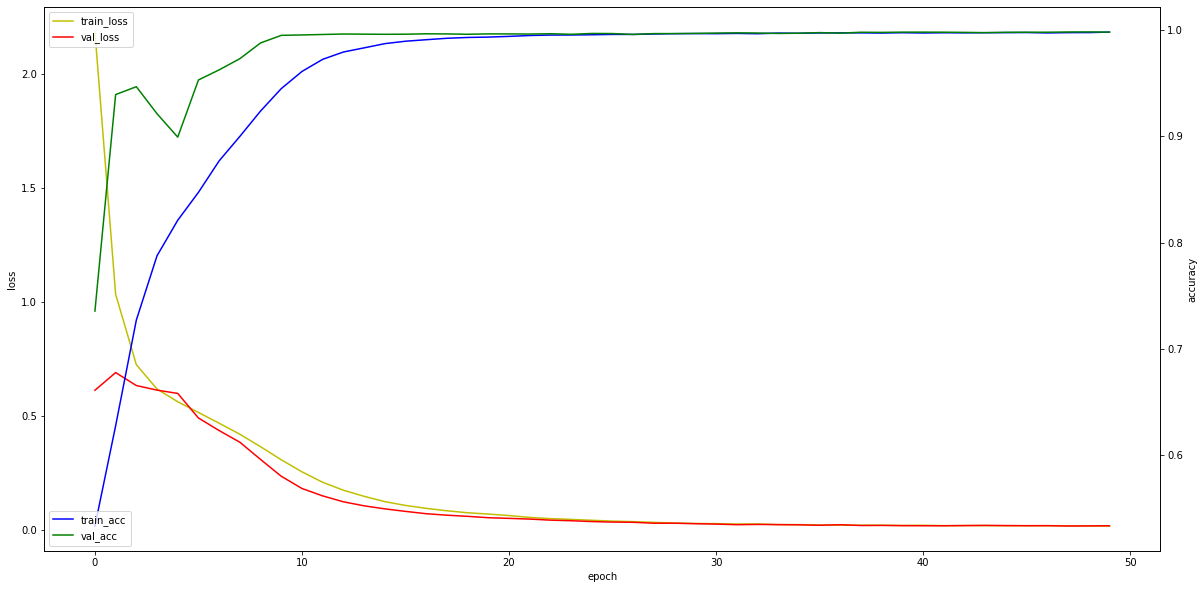

In [164]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

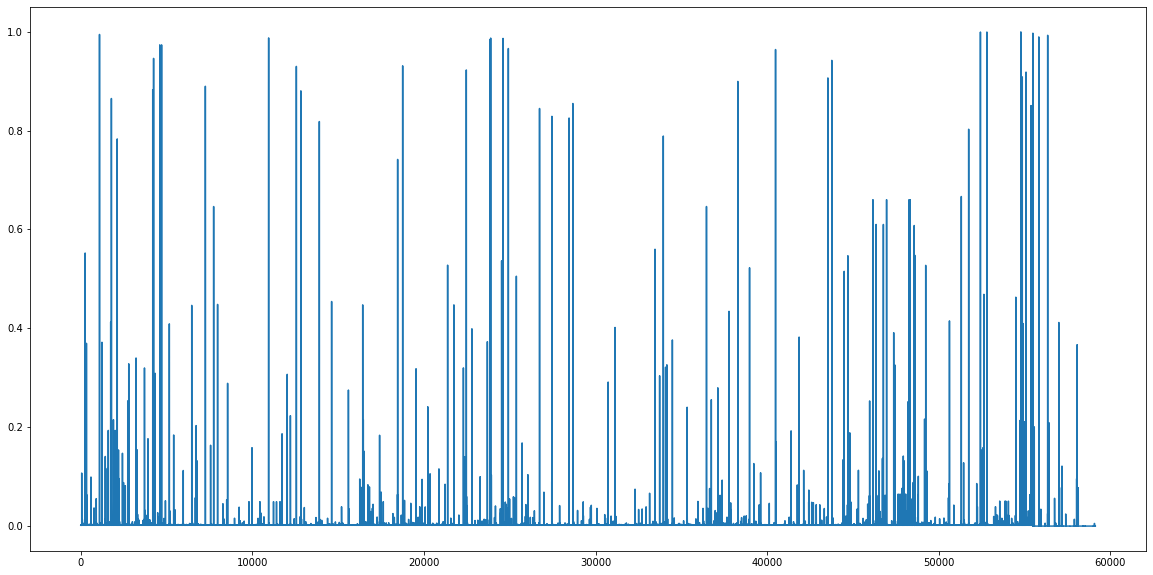

In [165]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test, ftr_etc_test], batch_size=160)
gap = np.abs(tidf_label_test - pred_test.reshape([-1,]))

plt.figure(figsize=(20,10))
plt.plot(gap)

In [166]:
*_, train_acc = model.evaluate([tidf_cond_train, tidf_gen_train, ftr_etc_train], tidf_label_train)
*_, valid_acc = model.evaluate([tidf_cond_valid, tidf_gen_valid, ftr_etc_valid], tidf_label_valid)
valid_acc, train_acc, '{:.3f}%'.format(valid_acc / train_acc * 100)

59281/59281 [==============================] - 7s 110us/step


(0.9990553465697273, 0.9990705953259394, '99.998%')

auc : 0.9999896760902881


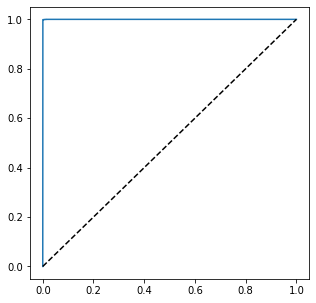

In [167]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(tidf_label_test, pred_test)
print('auc :', auc(fpr,tpr))

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,'-')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [ ]:
# 제출 준비

In [168]:
submit_df = pd.read_csv('./data/public_test.csv')

In [169]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited, etc = parse_sentence(item.text)
    # 일반 피쳐를 여기에서 etc에 넣는다
    etc.append(len(item.text))
    splited.append(etc)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2019-12-26 22:29:04.802295 0


In [170]:
test_conditioned = []
test_general = []
test_etc = []

original_idx = []
for unknown in unknowns:
    conditioned = []
    general = []
    for item in unknown[:-2]:
        if item[1] == True:
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    test_conditioned.append(list(conditioned))
    test_general.append(list(general))
    test_etc.append(unknown[-2])
    original_idx.append(unknown[-1])

In [171]:
tidf_conditioned = vectorizer_conditioned.transform(test_conditioned).toarray()
tidf_general = vectorizer_general.transform(test_general).toarray()
ftr_etc = np.array(test_etc)

In [172]:
pred_y = model.predict(x=[tidf_conditioned, tidf_general, ftr_etc], verbose=1)

1626/1626 [==============================] - 0s 87us/step


In [173]:
pred_y[pred_y > 1.0] = 1.0

In [174]:
submit_df['smishing'] = np.abs(pred_y)

In [175]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20191226_3.csv', index=False)